In [1]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.api import VAR 

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [2]:
os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_27224\2312531484.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_27224\2312531484.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_27224\2312531484.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [3]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [4]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [5]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)

In [6]:
data = data.dropna()

In [7]:
def plot_model_rmse_and_loss(history):
    
    #evaluating train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    #val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    #visualizing epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    #plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs / Training RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    #plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs / Training Loss')

    plt.show()

def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted', color='red')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()



In [21]:
n_train = 35064

features = ['total_aggregated']
feature_array = data[features].values

# Initialize the scaler
scaler = StandardScaler()

scaler.fit(feature_array[:n_train].reshape(-1,1))
scaled_array = scaler.transform(feature_array)

# Create a DataFrame from the observations
df = pd.DataFrame(scaled_array, columns=['total_aggregated'])


# Create 24 lags and store them as new columns in the DataFrame
for i in range(1, 25):
    df[f'lag_{i}'] = df['total_aggregated'].shift(i)

# Interpolate missing values
df = df.bfill()
# Define the number of train and test observations

# Separate the lags (features) and the observation (target)
#X = df.drop('total_aggregated', axis=1)
X = df['lag_24']
y = df['total_aggregated']

# Separate the features into training and test sets
X_train = X[:n_train]
X_test = X[n_train:]

y_train, y_test = y[:n_train], y[n_train:]

In [55]:
#n_forecast_steps = 24  # This could be 1 if you want to predict one step at a time
#window_size = 24

In [10]:
truth = feature_array[-len(y_test):]

In [168]:
## Fit the scaler on the training data and transform it
#X_train_scaled = scaler.fit_transform(X_train)
#
## Use the fitted scaler to transform the test data
#X_test_scaled = scaler.transform(X_test)
#
## Separate the target into training and test sets
#y_train, y_test = y[:n_train], y[n_train:]
#
## Fit the scaler on the training data and transform it
#y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
#
## Use the fitted scaler to transform the test data
#y_test_scaled = scaler.transform(y_test.values.reshape(-1,1))

In [8]:
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.003)

In [22]:
# Define the model
mlp = tf.keras.models.Sequential([
    Dense(10, activation='relu', input_shape=(1,)),

    Dense(10, activation='relu'),

    Dense(1, activation='linear')
])

mlp.summary() 

mlp.compile(optimizer=optimizer, loss=loss, metrics = metric)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 5)                 10        
                                                                 


 dense_7 (Dense)             (None, 5)                 30        
                                                                 
 dense_8 (Dense)             (None, 1)                 6         
                                                                 
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Assuming X_train, y_train, X_test, y_test have been prepared as before
history_X = X_train.copy()
history_y = y_train.copy()

In [24]:
window = 24*365*3 # INDICO WINDOW DI 3 ANNI 
n_forecast_steps = 24 # INDICO DI QUANTI STEP AHEAD FARE FORECASTING 

In [25]:
history_X = X_train.copy() # LA DIMENSIONE DEL TRAIN è DI 24*365*3 ORE -> 3 ANNI
history_y = y_train.copy()

predictions = [] # LISTA DELLE PREVISIONI
errors = [] # LISTA DEI RMSE PER GIORNO
days = 1 # COUNTER DEI GIORNI
for i in range(0, len(X_test), n_forecast_steps):
    t_end = i + n_forecast_steps # A PARTIRE DALLA POSIZIONE i DEL TEST SET INDICO FINO A QUALE POSIZONE SI FANNO LE PREVISIONI, OVVERO OGNI 24 ORE/POSIZIONI.
                                 # E.G.: SE L'INDICE è 0 SI FA FORECASTING FINO ALLA POSIZIONE 24 (0+24), SE L'INDICE è 24 FINO ALLA POSIZIONE 48 ECC
    if t_end > len(X_test):      
        t_end = len(X_test)
    X_test_block = X_test[i:t_end] # PRENDO IL BLOCCO DEL TEST SET SU CUI FARE FORECASTING USANDO LE POSIZIONI DICHIARATE PRIMA
    y_test_block = y_test[i:t_end]
    truth_block = truth[i:t_end]

    print('training and predicting for period', days)
    mlp.fit(history_X, history_y, epochs=100, verbose=0, batch_size=168, callbacks=[early_stopping]) # FACCIO TRAINING SULLA WINDOW USANDO 100 EPOCHE
                                                                                                         # L'ARGOMENTO "EARLY STOPPING" FA IN MODO CHE IL TRAINING SULLA WINDOW ATTUALE
                                                                                                         # SI STOPPI DOPO SE DOPO X EPOCHE (IN QUESTO CASO HO SETTATO IL PARAMETRO A 10)
                                                                                                         # LA LOSS (RMSE) NON DIMINUISCE 

    yhat = mlp.predict(X_test_block)                          # FACCIO LE PREVISIONI, LE RI-TRASFORMO NELLA SCALA ORIGINALE (PRIMA ERANO TRASFORMATE CON UNO SCALING PER VELOCIZZARE IL TRAINING)
                                                              # INSIEME AL BLOCCO DEL Y_TEST ATTUALE 
    yhat_rescaled = scaler.inverse_transform(yhat)

    rmse = sqrt(np.mean(truth_block - yhat_rescaled)**2)  # CALCOLO RMSE DEL GIORNO, POI APPENDO SIA RMSE CHE PREVISIONI ALLE RISPETTIVE LISTE
    errors.append(rmse)
    predictions.extend(yhat_rescaled)

    print('Mean Squared Error:', rmse)
    
    days = days + 1
    
    # Update the history with the latest "known" data
    history_X = pd.concat([history_X[n_forecast_steps:], X_test_block]) # FACCIO UPDATE DEL TRAINING SET SPOSTANDO LA WINDOW AVANTI DI UN GIORNO,
    history_y = pd.concat([history_y[n_forecast_steps:], y_test_block]) # ELIMINANDO LE 24 ORE INIZIALI E AGIGUNGENDO LE 24 ORE SU CUI SI è FATTO FORECAST (NON I FORECAST, I VALORI REALI)


training and predicting for period 1
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 12.501592726934524
training and predicting for period 2
6/6 [==============================] - 0s 801us/step
Mean Squared Error: 837.9739932105655
training and predicting for period 3
6/6 [==============================] - 0s 940us/step
Mean Squared Error: 855.7163899739584
training and predicting for period 4
6/6 [==============================] - 0s 801us/step
Mean Squared Error: 390.4517066592262
training and predicting for period 5
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 1187.358909970238
training and predicting for period 6
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 406.9335123697917
training and predicting for period 7
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 190.7650902157738
training and predicting for period 8
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 444

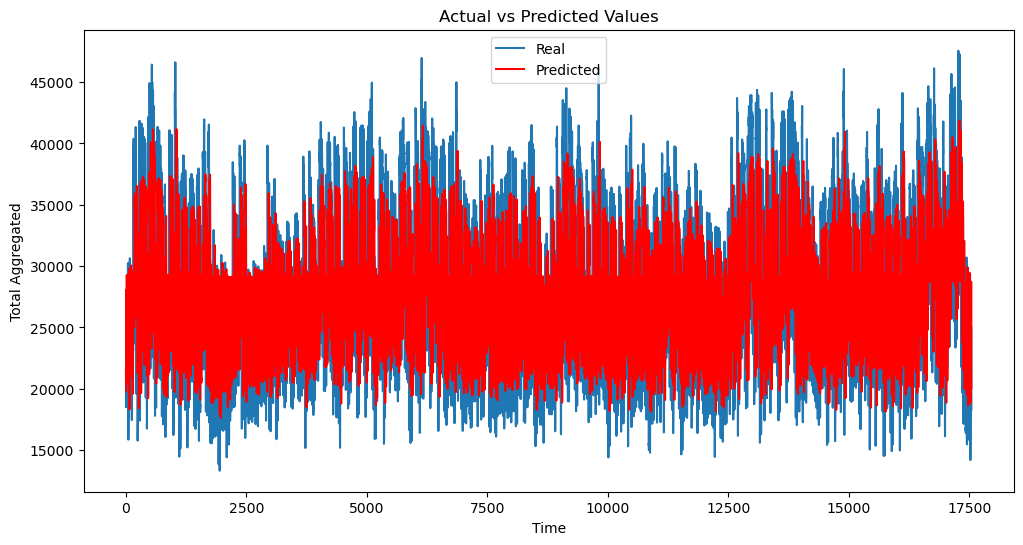

In [27]:
#y_pred_inv = scaler.inverse_transform(predictions)
#
## Plot the actual and predicted values
plot_preds_vs_actual(truth, predictions)
#rmse = sqrt(np.mean((truth - predictions)**2))

In [28]:
res = pd.DataFrame()
res['y_true'] = pd.Series(truth.flatten())
res['y_pred'] = predictions

rmse = sqrt(np.mean((res.y_true - res.y_pred)**2))
print('Mean Squared Error:', rmse)

Mean Squared Error: 4906.766960025715


# WEEKEND

In [29]:
features = ['total_aggregated', 'saturday', 'sunday']
feature_array = data[features].values
#window_size = 24


# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train, 0].reshape(-1,1))

# Transfom on both Training and Test data
scaled_feature = target_scaler.transform(feature_array[:, 0].reshape(-1, 1))

scaled_array = np.copy(feature_array)
scaled_array[:, 0] = scaled_feature.flatten()

# Create a DataFrame from the observations
df = pd.DataFrame(scaled_array, columns=['total_aggregated', 'sat', 'sun'])


# Create 24 lags and store them as new columns in the DataFrame
for i in range(1, 25):
    df[f'lag_{i}'] = df['total_aggregated'].shift(i)

# Interpolate missing values
df = df.bfill()
# Define the number of train and test observations

# Separate the lags (features) and the observation (target)
X = df[['lag_1', 'sat', 'sun']]
y = df['total_aggregated']

# Separate the features into training and test sets
X_train = X[:n_train]
X_test = X[n_train:]

y_train, y_test = y[:n_train], y[n_train:]

In [43]:
# Define the model
mlp2 = tf.keras.models.Sequential([
    Dense(10, activation='relu', input_shape=(3,)),
    Dense(10, activation='relu'),
    #Dense(1, activation='relu'),
    Dense(1, activation='linear')
])

mlp2.summary()
mlp2.compile(optimizer=optimizer, loss=loss, metrics = metric)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 5)                 20        
                                                                 
 dropout_6 (Dropout)         (None, 5)                 0         
                                                                 
 dense_25 (Dense)            (None, 5)                 30        
                                                                 
 dropout_7 (Dropout)         (None, 5)                 0         
                                                                 
 dense_26 (Dense)            (None, 1)                 6         
                                                                 
Total params: 56
Trainable params: 56
Non-trainable params: 0


_________________________________________________________________


In [44]:

history_X = X_train.copy() # LA DIMENSIONE DEL TRAIN è DI 24*365*3 ORE -> 3 ANNI
history_y = y_train.copy()

predictions2 = [] # LISTA DELLE PREVISIONI
errors2 = [] # LISTA DEI RMSE PER GIORNO
days = 1 # COUNTER DEI GIORNI
for i in range(0, len(X_test), n_forecast_steps):
    t_end = i + n_forecast_steps # A PARTIRE DALLA POSIZIONE i DEL TEST SET INDICO FINO A QUALE POSIZONE SI FANNO LE PREVISIONI, OVVERO OGNI 24 ORE/POSIZIONI.
                                 # E.G.: SE L'INDICE è 0 SI FA FORECASTING FINO ALLA POSIZIONE 24 (0+24), SE L'INDICE è 24 FINO ALLA POSIZIONE 48 ECC
    if t_end > len(X_test):      
        t_end = len(X_test)
    X_test_block = X_test[i:t_end] # PRENDO IL BLOCCO DEL TEST SET SU CUI FARE FORECASTING USANDO LE POSIZIONI DICHIARATE PRIMA
    y_test_block = y_test[i:t_end]
    truth_block = truth[i:t_end]

    print('training and predicting for period', days)
    mlp2.fit(history_X, history_y, epochs=100, verbose=0, batch_size=168, callbacks=[early_stopping]) # FACCIO TRAINING SULLA WINDOW USANDO 100 EPOCHE
                                                                                                         # L'ARGOMENTO "EARLY STOPPING" FA IN MODO CHE IL TRAINING SULLA WINDOW ATTUALE
                                                                                                         # SI STOPPI DOPO SE DOPO X EPOCHE (IN QUESTO CASO HO SETTATO IL PARAMETRO A 10)
                                                                                                         # LA LOSS (RMSE) NON DIMINUISCE 

    yhat = mlp2.predict(X_test_block)                          # FACCIO LE PREVISIONI, LE RI-TRASFORMO NELLA SCALA ORIGINALE (PRIMA ERANO TRASFORMATE CON UNO SCALING PER VELOCIZZARE IL TRAINING)
                                                              # INSIEME AL BLOCCO DEL Y_TEST ATTUALE 
    yhat_rescaled = scaler.inverse_transform(yhat)

    rmse = sqrt(np.mean(truth_block - yhat_rescaled)**2)  # CALCOLO RMSE DEL GIORNO, POI APPENDO SIA RMSE CHE PREVISIONI ALLE RISPETTIVE LISTE
    errors2.append(rmse)
    predictions2.extend(yhat_rescaled)

    print('Mean Squared Error:', rmse)
    
    days = days + 1
    
    # Update the history with the latest "known" data
    history_X = pd.concat([history_X[n_forecast_steps:], X_test_block]) # FACCIO UPDATE DEL TRAINING SET SPOSTANDO LA WINDOW AVANTI DI UN GIORNO,
    history_y = pd.concat([history_y[n_forecast_steps:], y_test_block]) # ELIMINANDO LE 24 ORE INIZIALI E AGIGUNGENDO LE 24 ORE SU CUI SI è FATTO FORECAST (NON I FORECAST, I VALORI REALI)

training and predicting for period 1
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 556.3041294642857
training and predicting for period 2
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 1123.554664248512
training and predicting for period 3
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 1260.2128324962798
training and predicting for period 4
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 1432.5843912760417
training and predicting for period 5
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 409.3525855654762
training and predicting for period 6
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 525.8916480654761
training and predicting for period 7
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 715.262951078869
training and predicting for period 8
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 382.82714

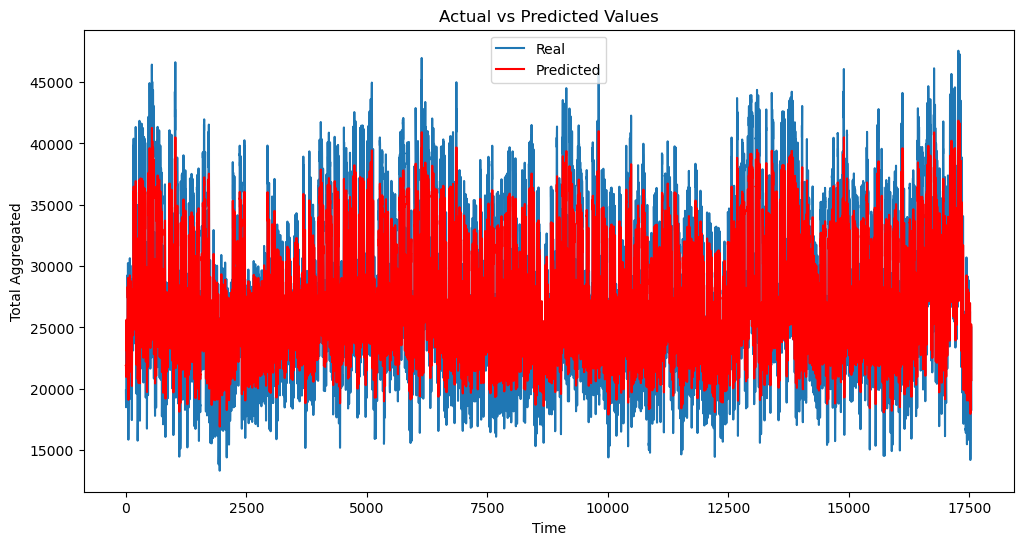

In [45]:
## Plot the actual and predicted values
plot_preds_vs_actual(truth, predictions2)

In [46]:
res['y_pred2'] = predictions2

rmse2 = sqrt(np.mean((res.y_true - res.y_pred2)**2))
print('Mean Squared Error:', rmse2)

Mean Squared Error: 2716.582595836173


# BUSINESS

In [47]:
features = ['total_aggregated', 'business hour']
feature_array = data[features].values

# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train, 0].reshape(-1,1))

# Transfom on both Training and Test data
scaled_feature = target_scaler.transform(feature_array[:, 0].reshape(-1, 1))

scaled_array = np.copy(feature_array)
scaled_array[:, 0] = scaled_feature.flatten()

# Create a DataFrame from the observations
df = pd.DataFrame(scaled_array, columns=['total_aggregated', 'business hour'])


# Create 24 lags and store them as new columns in the DataFrame
for i in range(1, 25):
    df[f'lag_{i}'] = df['total_aggregated'].shift(i)

# Interpolate missing values
df = df.bfill()
# Define the number of train and test observations

# Separate the lags (features) and the observation (target)
#X = df.drop('total_aggregated', axis=1)
X = df[['lag_1', 'business hour']]
y = df['total_aggregated']

# Separate the features into training and test sets
X_train = X[:n_train]
X_test = X[n_train:]

y_train, y_test = y[:n_train], y[n_train:]

In [52]:
# Define the model
mlp3 = tf.keras.models.Sequential([
    Dense(10, activation='relu', input_shape=(2,)),
    Dense(10, activation='relu'),
    Dense(1, activation='linear')
])

mlp3.summary()
mlp3.compile(optimizer=optimizer, loss=loss, metrics = metric)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 3)                 9         
                                                                 
 dropout_10 (Dropout)        (None, 3)                 0         
                                                                 
 dense_34 (Dense)            (None, 3)                 12        
                                                                 
 dropout_11 (Dropout)        (None, 3)                 0         
                                                                 
 dense_35 (Dense)            (None, 1)                 4         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [53]:
window = 24*365*3 # INDICO WINDOW DI 3 ANNI 
n_forecast_steps = 24*7# INDICO DI QUANTI STEP AHEAD FARE FORECASTING 

history_X = X_train.copy() # LA DIMENSIONE DEL TRAIN è DI 24*365*3 ORE -> 3 ANNI
history_y = y_train.copy()

predictions3 = [] # LISTA DELLE PREVISIONI
errors3 = [] # LISTA DEI RMSE PER GIORNO
days = 1 # COUNTER DEI GIORNI
for i in range(0, len(X_test), n_forecast_steps):
    t_end = i + n_forecast_steps # A PARTIRE DALLA POSIZIONE i DEL TEST SET INDICO FINO A QUALE POSIZONE SI FANNO LE PREVISIONI, OVVERO OGNI 24 ORE/POSIZIONI.
                                 # E.G.: SE L'INDICE è 0 SI FA FORECASTING FINO ALLA POSIZIONE 24 (0+24), SE L'INDICE è 24 FINO ALLA POSIZIONE 48 ECC
    if t_end > len(X_test):      
        t_end = len(X_test)
    X_test_block = X_test[i:t_end] # PRENDO IL BLOCCO DEL TEST SET SU CUI FARE FORECASTING USANDO LE POSIZIONI DICHIARATE PRIMA
    y_test_block = y_test[i:t_end]
    truth_block = truth[i:t_end]

    print('training and predicting for period', days)
    mlp3.fit(history_X, history_y, epochs=100, batch_size=168, verbose=0, callbacks=[early_stopping]) # FACCIO TRAINING SULLA WINDOW USANDO 100 EPOCHE
                                                                                                         # L'ARGOMENTO "EARLY STOPPING" FA IN MODO CHE IL TRAINING SULLA WINDOW ATTUALE
                                                                                                         # SI STOPPI DOPO SE DOPO X EPOCHE (IN QUESTO CASO HO SETTATO IL PARAMETRO A 10)
                                                                                                         # LA LOSS (RMSE) NON DIMINUISCE 

    yhat = mlp3.predict(X_test_block)                          # FACCIO LE PREVISIONI, LE RI-TRASFORMO NELLA SCALA ORIGINALE (PRIMA ERANO TRASFORMATE CON UNO SCALING PER VELOCIZZARE IL TRAINING)
                                                              # INSIEME AL BLOCCO DEL Y_TEST ATTUALE 
    yhat_rescaled = scaler.inverse_transform(yhat)

    rmse = sqrt(np.mean(truth_block - yhat_rescaled)**2)  # CALCOLO RMSE DEL GIORNO, POI APPENDO SIA RMSE CHE PREVISIONI ALLE RISPETTIVE LISTE
    errors3.append(rmse)
    predictions3.extend(yhat_rescaled)

    print('Mean Squared Error:', rmse)
    
    days = days + 1
    
    # Update the history with the latest "known" data
    history_X = pd.concat([history_X[n_forecast_steps:], X_test_block]) # FACCIO UPDATE DEL TRAINING SET SPOSTANDO LA WINDOW AVANTI DI UN GIORNO,
    history_y = pd.concat([history_y[n_forecast_steps:], y_test_block]) # ELIMINANDO LE 24 ORE INIZIALI E AGIGUNGENDO LE 24 ORE SU CUI SI è FATTO FORECAST (NON I FORECAST, I VALORI REALI)

training and predicting for period 1
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 1538.044410342262
training and predicting for period 2
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 656.8526901971726
training and predicting for period 3
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 941.232666015625
training and predicting for period 4
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 1157.9877348400298
training and predicting for period 5
6/6 [==============================] - 0s 1ms/step
Mean Squared Error: 379.49244326636904
training and predicting for period 6
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 415.35557338169644
training and predicting for period 7
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 85.01869419642857
training and predicting for period 8
6/6 [==============================] - 0s 2ms/step
Mean Squared Error: 482.1454

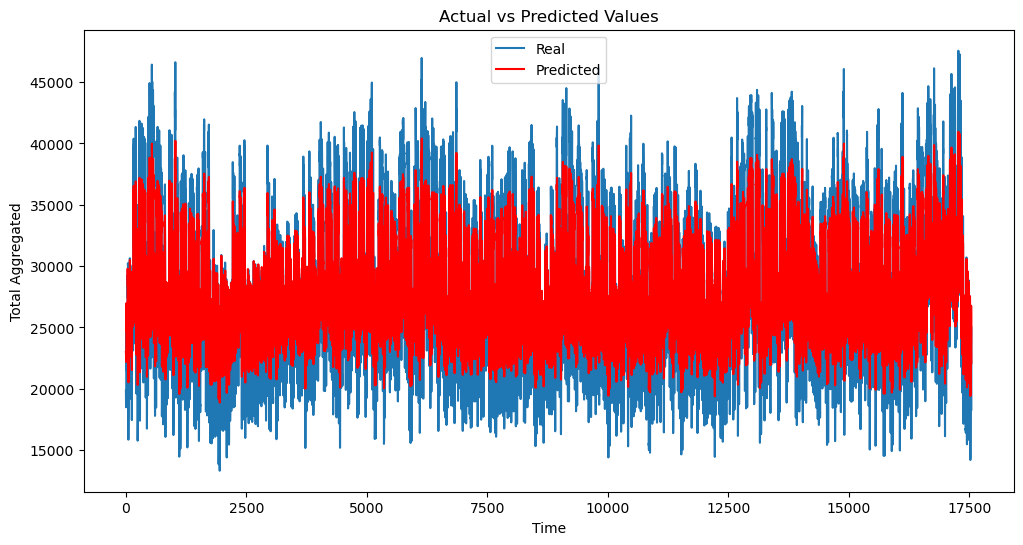

In [54]:
## Plot the actual and predicted values
plot_preds_vs_actual(truth, predictions3)

In [55]:
res['y_pred3'] = predictions3
rmse3 = sqrt(np.mean((truth - predictions3)**2))
print('Mean Squared Error:', rmse3)

Mean Squared Error: 2938.8753698076366


In [57]:
rmse1 = sqrt(np.mean((res.y_true - res.y_pred)**2))
print('Root Mean Squared Error just TS:', rmse1)
rmse2 = sqrt(np.mean((res.y_true - res.y_pred2)**2))
print('Root Mean Squared Error WE dummies:', rmse2)
rmse3 = sqrt(np.mean((res.y_true - res.y_pred3)**2))
print('Root Mean Squared Error BH dummy:', rmse3)

Root Mean Squared Error just TS: 4906.766960025715
Root Mean Squared Error WE dummies: 2716.582595836173
Root Mean Squared Error BH dummy: 2938.876486006174
